In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['GEM.tsv']


In [2]:
df = pd.read_csv("../input/GEM.tsv",header=0,delimiter="\t",quoting=3)
df.head()

submission_id  argument evaluation   ...     support  writing
0  SP-1511142447_1                    1   ...           1        0
1  SP-1603168425_1                    1   ...           0        0
2  SP-1603168425_2                    1   ...           1        0
3  SP-1603168919_1                    1   ...           1        0
4  SP-1603172361_1                    1   ...           1        0

[5 rows x 20 columns]

In [3]:
df_q1 = df[['question1']]
df_labels = df[['issue spotting']]
df_labels.head(3)


issue spotting
0               1
1               0
2               1

In [4]:
import matplotlib.pyplot as plt
import keras
from IPython.display import clear_output

%matplotlib inline

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()

        plt.show();


plot = PlotLearning()

Using TensorFlow backend.


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from eli5.lime import TextExplainer
import regex as re
import numpy as np


class KerasTextClassifier(BaseEstimator, TransformerMixin):
    '''Wrapper class for keras text classification models that takes raw text as input.'''
    
    def __init__(self, max_words=5000, input_length=100, emb_dim=32, n_classes=2, epochs=5, batch_size=32):
        self.max_words = max_words
        self.input_length = input_length
        self.emb_dim = emb_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.bs = batch_size
        self.model = self._get_model()
        self.tokenizer = Tokenizer(num_words=self.max_words+1,split=' ')
    
    def _get_model(self):
        input_text = Input((self.input_length,))
        text_embedding = Embedding(input_dim=self.max_words + 2, output_dim=self.emb_dim,
                                   input_length=self.input_length, mask_zero=False)(input_text)
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        bilstm = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.5))(text_embedding)
        x = concatenate([GlobalAveragePooling1D()(bilstm), GlobalMaxPooling1D()(bilstm)])
        x = Dropout(0.7)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.6)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.5)(x)
        out = Dense(units=self.n_classes, activation="softmax")(x)
        model = Model(input_text, out)
        model.compile(optimizer="adam",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
        return model
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.input_length, value=0)
    
    def _preprocess(self, texts):
        #tx1=texts.to_string(index=False).split('\n')
        #m = [re.sub(r"\d", "DIGIT", x) for x in tx1]
        print(len(m))
        print(len(m[0]))
        return list(texts.fillna("_##_").values)
    def fit(self, X, y):
        '''
        Fit the vocabulary and the model.
        
        :params:
        X: list of texts.
        y: labels.
        '''
        
        self.tokenizer.fit_on_texts(X)
        self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
        self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
        seqs = self._get_sequences(X)
        self.model.fit(seqs, y, batch_size=self.bs, epochs=self.epochs, validation_split=0.1,callbacks=[plot])
    
    def predict_proba(self, X, y=None):
        seqs = self._get_sequences(X)
        return self.model.predict(seqs)
    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    

In [6]:
text_model = KerasTextClassifier(epochs=20, max_words=2707, input_length=500)


In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
data_train, data_test, labels_train, labels_test = train_test_split(df_q1,df_labels,test_size=0.1,random_state=5)
y_train = to_categorical(labels_train, num_classes=2)
y_test = to_categorical(labels_test, num_classes=2)
train_X = data_train.fillna("_##_").values.tolist()
test_X = data_test.fillna("_##_").values.tolist()
train_X = [x[0] for x in train_X]
test_X = [x[0] for x in test_X]

In [8]:
tokenizer = Tokenizer(num_words=5001, filters='',split=' ' ,oov_token="UNK")
#list1 = ' '.join(str(x) for x in train_X)
#print(list1)
#print(train_X)
#list1 = ' '.join(x[0] for x in )
tokenizer.fit_on_texts(train_X)
seqs = tokenizer.texts_to_sequences(train_X)
#print(seqs)
maxlen = 200
data = pad_sequences(seqs, maxlen=maxlen)
print(data.max())
print(data)


2707
[[   0    0    0 ...    5    2  248]
 [   0    0    0 ...    2   91   78]
 [   0    0    0 ...  381 1162  229]
 ...
 [   0    0    0 ...   13   15   33]
 [   0    0    0 ... 1220    2  394]
 [   0    0    0 ...    2  293  454]]


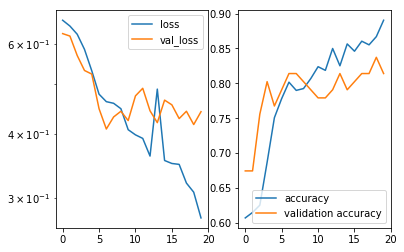

In [9]:
text_model.fit(train_X, y_train)
#data_train.head()

In [10]:
#np.argmax(y_test, axis=1)
#print(y_test)
#print(np.argmax(y_test, axis=1))
text_model.score(test_X,np.argmax(y_test, axis=1))


0.8

In [11]:
print(test_X[50])
print(np.argmax(y_test, axis=1)[50])
doc = test_X[50]
te = TextExplainer(random_state=5)
te.fit(doc, text_model.predict_proba)
te.show_prediction(target_names=['0','1'])


The discussion or debate is about the ethics of selling organs.  Janet Radcliffe – Richards begins to explain how there is a shortage of organs and that buying them is the only hope for some people who have a dire need.     The interviewer objections are exploitation of poor people selling their organs to wealthy people.  But Janet Radcliffe – Richards states that the person selling the organ most likely wants the money more than they want the organ.  She also mentions that if this is legalized and there is a control of the exchange then exploitation can be eliminated altogether.
1


In [12]:
from sklearn.tree import DecisionTreeClassifier
te5 = TextExplainer(clf=DecisionTreeClassifier(max_depth=2), random_state=5)
te5.fit(doc, text_model.predict_proba)
print(te5.metrics_)
te5.show_weights()

{'mean_KL_divergence': 0.06403806846380643, 'score': 0.8865918481079874}
